In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os


In [3]:
# Load dataset
path = r"C:\Users\Tiffany\Downloads\KULIAH\SEMESTER V\DEEP LEARNING\EKSPLORASI\LSTM VS RNN\RNN-vs-LSTM-News-Category-Classification\News_Category_Dataset_v3.json"

df = pd.read_json(path, lines=True)
df.head()

print(df[['headline', 'category']])

                                                 headline   category
0       Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS
1       American Airlines Flyer Charged, Banned For Li...  U.S. NEWS
2       23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY
3       The Funniest Tweets From Parents This Week (Se...  PARENTING
4       Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS
...                                                   ...        ...
209522  RIM CEO Thorsten Heins' 'Significant' Plans Fo...       TECH
209523  Maria Sharapova Stunned By Victoria Azarenka I...     SPORTS
209524  Giants Over Patriots, Jets Over Colts Among  M...     SPORTS
209525  Aldon Smith Arrested: 49ers Linebacker Busted ...     SPORTS
209526  Dwight Howard Rips Teammates After Magic Loss ...     SPORTS

[209527 rows x 2 columns]


In [4]:
# Preprocessing Data
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemm = WordNetLemmatizer()

def text_preprocess(text):
    text = text.lower()                            # 1. lowercase
    text = re.sub(r'http\S+', '', text)            # 2. remove url
    text = re.sub(r'[^a-z\s]', '', text)           # 3. remove punctuation & numbers
    tokens = text.split()                          # 4. tokenization
    tokens = [w for w in tokens if w not in stop_words]  # 5. remove stopwords
    tokens = [lemm.lemmatize(w) for w in tokens]   # 6. lemmatization
    return " ".join(tokens)

def csv_preprocess(df):
    # Hapus data duplikasi pada kolom headline
    df = df.drop_duplicates(subset='headline', keep='first')
        
    # Remove barus dengan null values
    df = df.dropna()
        
    # Reset index setelah penghapusan baris
    df = df.reset_index(drop=True)
        
    return df

pd.set_option('display.max_colwidth', None)
df['cleaned_headline'] = df['headline'].apply(text_preprocess)
df = csv_preprocess(df)
df[['headline', 'cleaned_headline', 'category']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tiffany\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tiffany\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,headline,cleaned_headline,category
0,Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters,million american roll sleeve omicrontargeted covid booster,U.S. NEWS
1,"American Airlines Flyer Charged, Banned For Life After Punching Flight Attendant On Video",american airline flyer charged banned life punching flight attendant video,U.S. NEWS
2,23 Of The Funniest Tweets About Cats And Dogs This Week (Sept. 17-23),funniest tweet cat dog week sept,COMEDY
3,The Funniest Tweets From Parents This Week (Sept. 17-23),funniest tweet parent week sept,PARENTING
4,Woman Who Called Cops On Black Bird-Watcher Loses Lawsuit Against Ex-Employer,woman called cop black birdwatcher loses lawsuit exemployer,U.S. NEWS


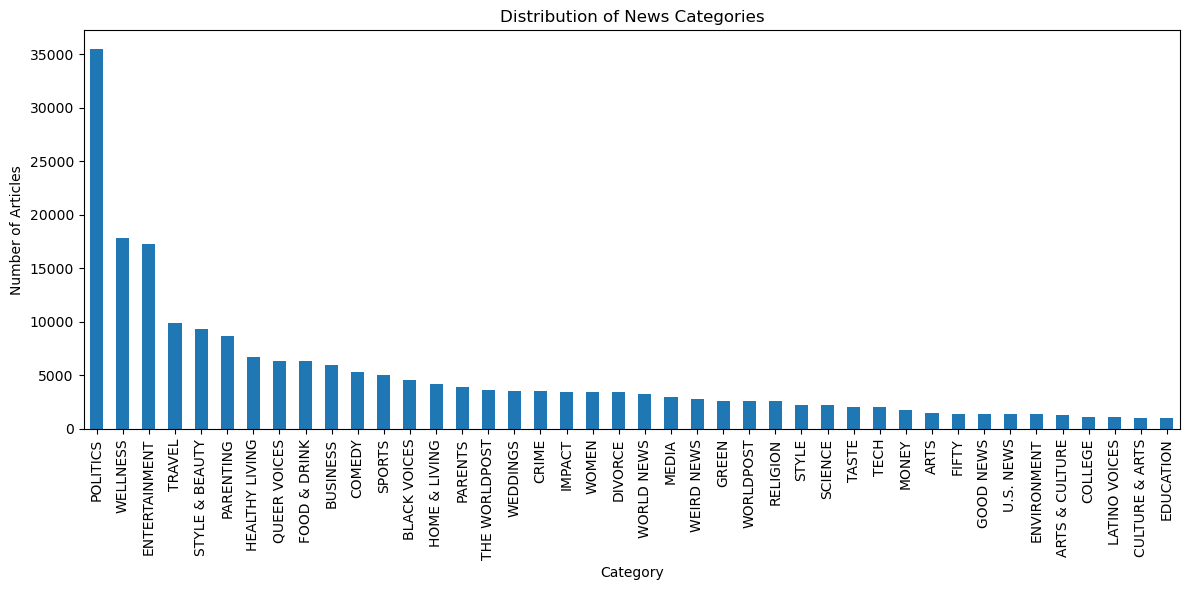

In [5]:
import matplotlib.pyplot as plt
# Count unique categories
category_counts = df['category'].value_counts()

# Plot the category distribution
plt.figure(figsize=(12, 6))
category_counts.plot(kind='bar')
plt.title('Distribution of News Categories')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [6]:
categories_to_keep = ['WELLNESS', 'ENTERTAINMENT', 'TRAVEL', 'STYLE & BEAUTY', 'PARENTING', 'FOOD & DRINK']

# Create a mapping dictionary for encoding
category_mapping = {
    'WELLNESS': 0,
    'ENTERTAINMENT': 1,
    'TRAVEL': 2,
    'STYLE & BEAUTY': 3,
    'PARENTING': 4,
    'FOOD & DRINK': 5
}

# Fix the filtering - use .keys() method
df = df[df['category'].isin(category_mapping.keys())]

# Apply the encoding to the category column
df['category'] = df['category'].map(category_mapping)

print(df['category'].value_counts())

category
0    17870
1    17319
2     9873
3     9323
4     8723
5     6330
Name: count, dtype: int64


In [7]:
# Balance the dataset by limiting each category to the minimum count
min_samples = df['category'].value_counts().min()
print(f"Minimum samples per category: {min_samples}")

# Sample the same number of rows from each category
df_balanced = df.groupby('category', group_keys=False).apply(
    lambda x: x.sample(n=min_samples, random_state=42)
)

# Reset index and shuffle
df_balanced = df_balanced.reset_index(drop=True)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Update df with balanced dataset
df = df_balanced

print(f"\nBalanced dataset shape: {df.shape}")
print(f"\nCategory distribution after balancing:")
print(df['category'].value_counts().sort_index())

Minimum samples per category: 6330

Balanced dataset shape: (37980, 7)

Category distribution after balancing:
category
0    6330
1    6330
2    6330
3    6330
4    6330
5    6330
Name: count, dtype: int64


C:\Users\Tiffany\AppData\Local\Temp\ipykernel_22780\4130417362.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('category', group_keys=False).apply(


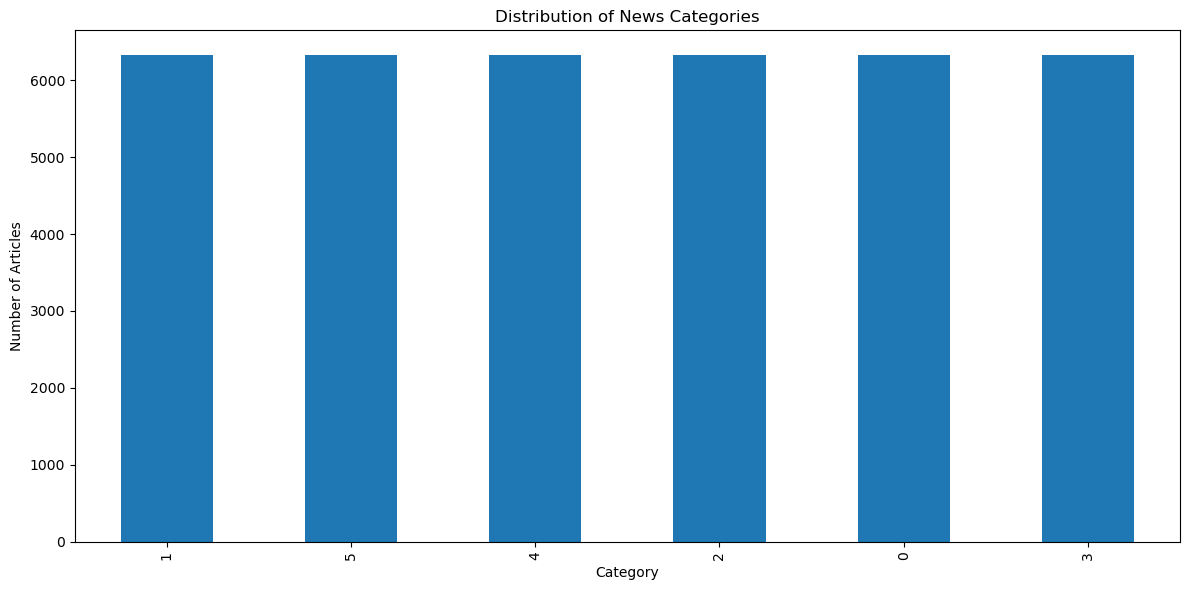

In [8]:
import matplotlib.pyplot as plt
# Count unique categories
category_counts = df['category'].value_counts()

# Plot the category distribution
plt.figure(figsize=(12, 6))
category_counts.plot(kind='bar')
plt.title('Distribution of News Categories')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [9]:
print(df['category'].value_counts())
print("Total data:", len(df))

category
1    6330
5    6330
4    6330
2    6330
0    6330
3    6330
Name: count, dtype: int64
Total data: 37980


In [13]:
# Mengubah teks menjadi vector (Tokenizing)
import tensorflow as tf

from sklearn.model_selection import train_test_split

pad_sequences = tf.keras.preprocessing.sequence.pad_sequences
Tokenizer = tf.keras.preprocessing.text.Tokenizer

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned_headline'])

sequences = tokenizer.texts_to_sequences(df['cleaned_headline'])

MAX_LEN = 12

X_padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')


X_train, X_test, y_train, y_test = train_test_split(
    X_padded, df['category'], test_size=0.2, random_state=42, stratify=df['category']
)


In [14]:
# Arsitektur model LSTM

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.0001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 128),
    tf.keras.layers.LSTM(128, dropout=0.25, return_sequences=True),
    tf.keras.layers.LSTM(64, dropout=0.25, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.6005 - loss: 1.0614 - val_accuracy: 0.7773 - val_loss: 0.6817 - learning_rate: 0.0010
Epoch 2/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8269 - loss: 0.5379 - val_accuracy: 0.8123 - val_loss: 0.5778 - learning_rate: 0.0010
Epoch 3/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8760 - loss: 0.3965 - val_accuracy: 0.8090 - val_loss: 0.6101 - learning_rate: 0.0010
Epoch 4/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9037 - loss: 0.3137 - val_accuracy: 0.8029 - val_loss: 0.6623 - learning_rate: 0.0010
Epoch 5/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9358 - loss: 0.2163 - val_accuracy: 0.8140 - val_loss: 0.6568 - learning_rate: 2.0000e-04


In [ ]:
model.evaluate(X_test, y_test)

238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8123 - loss: 0.5778


[0.577777624130249, 0.8122696280479431]

In [ ]:
# Get predictions (probabilities for all 6 classes)
predictions = model.predict(X_test)

# Show shape: should be (num_samples, 6)
print(f"Predictions shape: {predictions.shape}")
print(f"\nFirst 5 predictions:")
print(predictions[:5])

# For each prediction, you get 6 probabilities that sum to 1.0
print(f"\nFirst sample probabilities (sum={predictions[0].sum():.4f}):")
for i, prob in enumerate(predictions[0]):
    print(f"  Class {i}: {prob:.4f} ({prob*100:.2f}%)")

# Get the predicted class (highest probability)
predicted_classes = np.argmax(predictions, axis=1)
print(f"\nFirst 10 predicted classes: {predicted_classes[:10]}")
print(f"First 10 actual classes: {y_test.values[:10]}")

238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Predictions shape: (7596, 6)

First 5 predictions:
[[0.00278183 0.00115384 0.9881441  0.00199563 0.00156413 0.0043605 ]
 [0.02683388 0.01132938 0.06220162 0.00998886 0.00301195 0.8866344 ]
 [0.00365357 0.00177012 0.98148614 0.00310259 0.0018692  0.00811843]
 [0.953123   0.00209868 0.0077904  0.00508635 0.02325468 0.00864687]
 [0.5027862  0.02502342 0.02305185 0.03136901 0.37283418 0.04493536]]

First sample probabilities (sum=1.0000):
  Class 0: 0.0028 (0.28%)
  Class 1: 0.0012 (0.12%)
  Class 2: 0.9881 (98.81%)
  Class 3: 0.0020 (0.20%)
  Class 4: 0.0016 (0.16%)
  Class 5: 0.0044 (0.44%)

First 10 predicted classes: [2 5 2 0 0 2 0 4 5 0]
First 10 actual classes: [2 5 2 0 0 2 0 4 5 0]
